##Alunos: Gabriel e Guilherme

Vizualização dos pesos foi baseado no trabalho da Gabriela Surita

O objetivo deste notebook é visualizar as camadas de atenção cruzada na rede de legendas automáticas usando EfficientNet e T5.

# Setup do ambiente

In [ ]:
# % pip install sentencepiece

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.2 MB/s 


In [ ]:
!pip3 install -q --upgrade efficientnet_pytorch  \
                           transformers \
                           pytorch_lightning \
                           sacrebleu \
                           h5py

     |████████████████████████████████| 4.4 MB 5.8 MB/s 
     |████████████████████████████████| 585 kB 62.8 MB/s 
     |████████████████████████████████| 92 kB 14.1 MB/s 
     |████████████████████████████████| 4.1 MB 49.7 MB/s 
     |████████████████████████████████| 596 kB 76.1 MB/s 
     |████████████████████████████████| 101 kB 15.7 MB/s 
     |████████████████████████████████| 6.6 MB 85.1 MB/s 
     |████████████████████████████████| 419 kB 57.9 MB/s 
     |████████████████████████████████| 140 kB 54.9 MB/s 
     |████████████████████████████████| 1.1 MB 81.4 MB/s 
     |████████████████████████████████| 271 kB 85.2 MB/s 
     |████████████████████████████████| 144 kB 70.1 MB/s 
     |████████████████████████████████| 94 kB 1.8 MB/s 


In [ ]:
# Importar todos os pacotes de uma só vez para evitar duplicados ao longo do notebook.
import gzip
import os
import pytorch_lightning as pl
import random
import sacrebleu
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import json

from google.colab import drive

from pytorch_lightning.callbacks import ModelCheckpoint

from efficientnet_pytorch import EfficientNet

from transformers import T5ForConditionalGeneration
from transformers import T5Tokenizer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from matplotlib import pyplot as plt
import h5py


device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.cpu_count(), torch.cuda.get_device_name() if device == "cuda" else None

(4, 'Tesla P100-PCIE-16GB')

# Download do Dataset

Download do dataset MS COCO reduzido para 23k exemplos:

In [ ]:
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5

--2022-07-06 22:29:56--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 142.251.8.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289777 (283K) [application/json]
Saving to: ‘TEST_CAPTIONS_coco_5_cap_per_img.json’

TEST_CAPTIONS_coco_ 100%[===================>] 282.99K  --.-KB/s    in 0.002s  

2022-07-06 22:29:56 (152 MB/s) - ‘TEST_CAPTIONS_coco_5_cap_per_img.json’ saved [289777/289777]

--2022-07-06 22:29:56--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.128|:443... connected.
HTTP request sent,

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


O dataset deve conter 23520, 1052 e 1047 imagens de treino, validação e teste.

In [ ]:
import random
import json
import h5py

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


# Normalization suggested by the EfficientNet library when trained with adversarial examples.
# https://github.com/lukemelas/EfficientNet-PyTorch#update-january-23-2020
transform = transforms.Compose([
    transforms.Lambda(lambda img: img * 2.0  - 1.0),
])


class CaptioningDataset(Dataset):
    """
    Dataset that loads image instances lazily to memory.
    """

    def __init__(self, img_file, target_file, img_transform=lambda x: x, text_transform=lambda x: x):
        
        # We need to defer loading the images as h5py files cant be forked.
        # Ref: https://github.com/pytorch/pytorch/issues/11929
        self.img_file = img_file
        self.images = None
        
        self.targets = json.load(open(target_file, "r"))

        self.img_transform = img_transform
        self.text_transform = text_transform

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
    
        if not self.images:
            self.images = h5py.File(self.img_file, 'r') 
            
        img = self.images["images"][idx]
        cap = self.targets[idx]

        # Convert to float.
        img = img.astype(float)

        # Normalize image between 0 and 1.
        img = (img - img.min()) / np.max([img.max() - img.min(), 1])
                
        return self.img_transform(img), self.text_transform(cap)

    def __del__(self):
        if self.images:
            self.images.close()
    

train_set = CaptioningDataset("./TRAIN_IMAGES_coco_5_cap_per_img.hdf5", "./TRAIN_CAPTIONS_coco_5_cap_per_img.json", img_transform=transform)
val_set = CaptioningDataset("./VAL_IMAGES_coco_5_cap_per_img.hdf5", "./VAL_CAPTIONS_coco_5_cap_per_img.json", img_transform=transform)
test_set = CaptioningDataset("./TEST_IMAGES_coco_5_cap_per_img.hdf5", "./TEST_CAPTIONS_coco_5_cap_per_img.json", img_transform=transform)

In [ ]:
'''
A função collate_any seleciona um label aleatório dentre os 5 correspondentes a figura,
e uma vez definido o label realiza-ra o tokenização do mesmo de ocordo com o encoded de
T5. Sendo este usado no Dataset de treino
'''
# tokenizer = T5Tokenizer.from_pretrained('t5-small')
# tokenizer = T5Tokenizer.from_pretrained('google/t5-v1_1-base')
tokenizer = T5Tokenizer.from_pretrained('t5-base')

def collate_any(batch):
   
    imgs = torch.tensor(np.array([r[0] for r in batch]), dtype=torch.float)
    labels = np.array([random.choice(r[1]) for r in batch])
    
    batch_tokens = tokenizer.batch_encode_plus(
        labels,
        padding="longest",
        return_tensors="pt")['input_ids']

    return imgs, labels, batch_tokens

'''
 Um processo semelhante é aplicado pela collate_all, entretanto neste usa-se
 os 5 labels de cada imagem, passando eles pelo tokenizador. Sendo este metodo
 usado para os datasets de validação e teste.
'''
def collate_all(batch):
  
    imgs = torch.tensor(np.array([r[0] for r in batch]), dtype=torch.float)
    labels = np.array([r[1] for r in batch])

    encoded = [tokenizer.batch_encode_plus(label, 
                                           padding="longest", 
                                           return_tensors='pt')['input_ids']
    for label in labels]
            
    return imgs, labels, encoded

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


#Analisando Dataset

In [ ]:
train_loader = DataLoader(train_set,
                          batch_size=10,
                          collate_fn=collate_any)

val_loader = DataLoader(val_set,
                        batch_size=10,
                        collate_fn=collate_all)

test_loader = DataLoader(test_set,
                         batch_size=10,
                         collate_fn=collate_all)

In [ ]:
from nltk.translate import meteor
from nltk import word_tokenize

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.translate import bleu
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4

def metricas(sentences):

    bs, b4, me = 0, 0, 0
    for i in range(5):
        h = [0, 1, 2, 3, 4]
        s = h.remove(i)

        bs += bleu([sentences[k].split() for k in h], sentences[i].split(),(1,),)*100
        b4 += bleu([sentences[k].split() for k in h], sentences[i].split(), smoothing_function=smoothie)*100
        me += meteor([word_tokenize(sentences[k]) for k in h], word_tokenize(sentences[i]))*100

    b4_mean  = b4/5
    bs_mean  = bs/5
    meteor_m = me/5

    # print('Bleu-Score:', round(bs_mean, 4))
    # print('Bleu-4:    ', round(b4_mean, 4))
    # print('Meteor:    ', round(meteor_m, 4))

    return b4_mean, bs_mean, meteor_m

# metricas(sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
len(train_loader)

2352

In [ ]:
b4_mean, bs_mean, meteor_m = 0, 0, 0
exemplos = 0
i = 0
for imgs, labels, tokens in train_loader:

    exemplos += labels.shape[0]

    for i in range(len(labels)):
      b4, bs, me = metricas(labels[i])

      b4_mean  += b4
      bs_mean  += bs
      meteor_m += me

    i += 1
    if i == 4: break

print('Bleu-Score:', round(bs_mean/exemplos, 4))
print('Bleu-4:    ', round(b4_mean/exemplos, 4))
print('Meteor:    ', round(meteor_m/exemplos, 4))

Bleu-Score: 58.1675
Bleu-4:     16.9253
Meteor:     46.4747


In [ ]:
b4_mean, bs_mean, meteor_m = 0, 0, 0
exemplos = 0
i = 0
for imgs, labels, tokens in train_loader:

    exemplos += labels.shape[0]

    for i in range(len(labels)):
      b4, bs, me = metricas(labels[i])

      b4_mean  += b4
      bs_mean  += bs
      meteor_m += me

    i += 1
    if i == 4: break

print('Bleu-Score:', round(bs_mean/exemplos, 4))
print('Bleu-4:    ', round(b4_mean/exemplos, 4))
print('Meteor:    ', round(meteor_m/exemplos, 4))

Bleu-Score: 4.6939
Bleu-4:     4.6939
Meteor:     7.9167


In [ ]:
b4_mean, bs_mean, meteor_m = 0, 0, 0
exemplos = 0
j = 0
for imgs, labels, tokens in train_loader:

    exemplos += labels.shape[0]

    print(labels)

    for i in range(len(labels)):
      b4, bs, me = metricas(labels[i])

      b4_mean  += b4
      bs_mean  += bs
      meteor_m += me

    j += 1
    if j == 1:
      break

print('Bleu-Score:', round(bs_mean/exemplos, 4))
print('Bleu-4:    ', round(b4_mean/exemplos, 4))
print('Meteor:    ', round(meteor_m/exemplos, 4))

['a woman is holding a cat in her kitchen'
 'A group of people riding on the back of a loaded red pickup truck.'
 'A bunch of people aboard a boat with wheels. '
 'three bicycle riders some trees and a pigeon'
 'A toliet sitting on a curb in front of a house.'
 'A donut on the antenna of a car.'
 'A cat sitting on a wheel of a vehicle.'
 'An airplane flies over a street with many cars.'
 'A guy standing in a very dark room with a small window.'
 'A horse drawn carriage parked on the street.']
Bleu-Score: 4.0
Bleu-4:     4.0
Meteor:     6.0


In [ ]:
b4_mean, bs_mean, meteor_m = 0, 0, 0
exemplos = 0
for imgs, labels, tokens in val_loader:

    exemplos += labels.shape[0]

    for i in range(len(labels)):
      b4, bs, me = metricas(labels[i])

      b4_mean  += b4
      bs_mean  += bs
      meteor_m += me

print('Bleu-Score:', round(bs_mean/exemplos, 4))
print('Bleu-4:    ', round(b4_mean/exemplos, 4))
print('Meteor:    ', round(meteor_m/exemplos, 4))

Bleu-Score: 58.5309
Bleu-4:     17.5581
Meteor:     47.1368


In [ ]:
b4_mean, bs_mean, meteor_m = 0, 0, 0
exemplos = 0
for imgs, labels, tokens in test_loader:

    exemplos += labels.shape[0]

    for i in range(len(labels)):
      b4, bs, me = metricas(labels[i])

      b4_mean  += b4
      bs_mean  += bs
      meteor_m += me

print('Bleu-Score:', round(bs_mean/exemplos, 4))
print('Bleu-4:    ', round(b4_mean/exemplos, 4))
print('Meteor:    ', round(meteor_m/exemplos, 4))

Bleu-Score: 57.7987
Bleu-4:     16.9294
Meteor:     46.4464


# Criando Dataloaders para teste de alinhamento

Para isto são definidos a seguir Dataloaders de validação e treino, como os parâmetros abaixo. 

In [ ]:
params = {
    'batch_size_train': 4,
    'num_workers': 1,
    'seq_len': 64
}

In [ ]:
train_loader = DataLoader(train_set,
                          batch_size=params['batch_size_train'],
                          num_workers=os.cpu_count(),
                          collate_fn=collate_any)

val_loader = DataLoader(val_set,
                        batch_size=params['batch_size_train'],
                        num_workers=os.cpu_count(),
                        collate_fn=collate_all)

val_loader = DataLoader(val_set,
                        batch_size=params['batch_size_train'],
                        num_workers=os.cpu_count(),
                        collate_fn=collate_all)

# Avaliando o DataLoader Validação

Primeiramente será avaliado o Dataloader de validação gerado, onde este apresenta 5 Labels para cada uma das imagens conforme indicado a seguir:

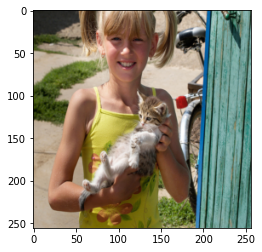

tensor([11874,    16,     3,     9,  5040,   420,  3609,     3,     9, 25573,
           16,   160,   223,  6178,     1])
tensor([  71, 1021, 3202,   19, 3609,    3,    9,  422, 1712,    5,    1,    0,
           0,    0,    0])
tensor([   71,  3202,  3993,     7,    38,   255,  4532,     3,     9,     3,
          157, 17132,  1712,     5,     1])
tensor([11874,    28,     3,     9,  4459,  8677,  3609,     3,     9,   422,
         1712,     1,     0,     0,     0])
tensor([   71,   385,  3202,  3609,     3,     9, 25573,   416,    12,     3,
            9,  1692,  8227,     5,     1])


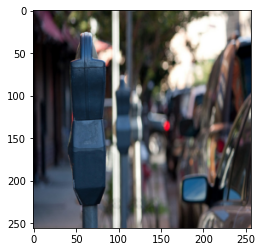

tensor([   71,  7358,    13,  2948,     3, 16669,    30,     3,     9,  2815,
           28,  3078,  8848,     5,     1,     0])
tensor([  71, 3078,    3, 4401,   30,    3,    9, 2815,   57,    3,    9,  443,
          28, 2117,    5,    1])
tensor([  71,  939,   13, 3078, 8848,   11, 2948,   33, 1069,  416,   12,  284,
         119,    5,    1,    0])
tensor([   71,  7358,    13,     3, 16669,  2948,  3823,   416,    12,  3078,
         8848,     5,     1,     0,     0,     0])
tensor([  71, 3078,    3, 4401,   30,    3,    9, 2815,   28, 2948,    1,    0,
           0,    0,    0,    0])


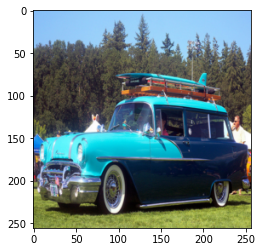

tensor([  389,   625,  2478, 25636,    28,     3,     9, 12245,  1976,    30,
          420,    13,    34,     5,     1])
tensor([  389,   625,   443,    28, 12245,  1976,     7,    30,     8,   420,
            5,     1,     0,     0,     0])
tensor([ 389,  625, 1689, 7445,  659, 1692,   11, 2164, 1692,    5,    1,    0,
           0,    0,    0])
tensor([   71,   443,    28,   128, 12245,  1976,     7,    16,     3,     9,
         1057,     5,     1,     0,     0])
tensor([   37,   625,     3, 19084,   443,    19,  6771,   128,  9337, 12245,
         1976,     7,     5,     1,     0])


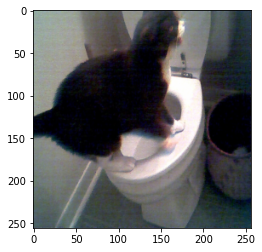

tensor([  71, 1712, 4125,   30,    8, 6699, 3047, 3143,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0])
tensor([   71,  1712,  4125,    30,     3,     9,  6699,    28,    46,   539,
        12533,     5,     1,     0,     0,     0,     0,     0])
tensor([   71, 16810,   651,  1554,    13,     3,     9,  1712,  4125,    30,
            3,     9,  6699,     5,     1,     0,     0,     0])
tensor([  71, 1712,   19,  399, 4513,   30,    8,  420,   13,    3,    9, 6699,
        3143,   16,    8, 2582,    5,    1])
tensor([   71,  1712,    30,     8, 12533,    13,     3,     9,  6699,   479,
        29404,    15,    26,     5,     1,     0,     0,     0])


In [ ]:
# Val loader usa o collate_all e retorna os 5 labels de cada imagem
imgs, tokens, labels = next(iter(val_loader))
for img, label in zip(imgs, labels):
    # Para apresentar as imagens é necessario desfazer a normalização empregada nas imagens
    plt.imshow((img.numpy().transpose(1, 2, 0)+1)/2) # adversarial
    plt.show()
    for caption in label:
      print(caption)

# Avaliando o DataLoader Treino

A seguir será avaliado o Dataloader de treino gerado, onde este apresenta apenas 1 Label para cada uma das imagens, sendo ele escolhido de forma aleatória dentre os 5 caracteristicos da imagem.

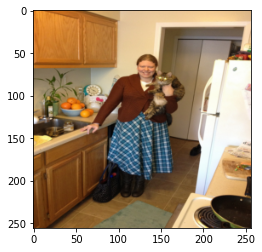

tensor([   3,    9, 2335,   19, 3609,    3,    9, 1712,   16,  160, 1228,    1,
           0,    0,    0,    0,    0])


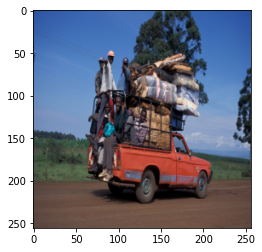

tensor([   71,  4072,     3, 11078,     3,     9,   508,   866,    13,  1173,
           11,     3,     9,   360,   151,     5,     1])


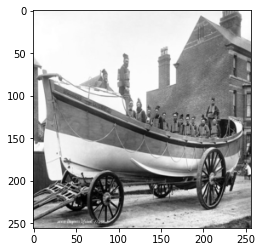

tensor([   71,  3432,    19,   271,     3, 10671,    30,     3,     9,  6943,
            1,     0,     0,     0,     0,     0,     0])


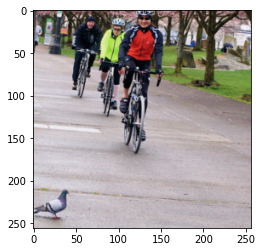

tensor([   71,  9502,   413,    13,   151,    30, 12679,     7,  1107,   323,
            3,     9,  2815,     5,     1,     0,     0])


In [ ]:
imgs, tokens,labels = next(iter(train_loader))
for img, label in zip(imgs, labels):
    # Desfazendo a normalização da imagem
    plt.imshow((img.numpy().transpose(1, 2, 0)+1)/2) # Normalização da efn adversarial
    plt.show()
    print(label)

# Treinando

In [ ]:
class T5Finetuner(pl.LightningModule):

    def __init__(self, train_dataloader, val_dataloader, test_dataloader, params):
        super(T5Finetuner, self).__init__()

        self.params = params
        
        self._train_dataloader = train_dataloader
        self._val_dataloader   = val_dataloader
        self._test_dataloader  = test_dataloader

        # Features da efficient net atuarão como as features do encoder do T5
        self.encoder = EfficientNet.from_pretrained('efficientnet-b0', advprop=True)
        self.decoder = T5ForConditionalGeneration.from_pretrained(params['model_name'])

        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Pra converter a saída da efn para o decoder do t5
        self.bridge = nn.Conv2d(in_channels=112, out_channels=self.decoder.config.d_model, kernel_size=1)

        self.tokenizer = T5Tokenizer.from_pretrained(params['model_name'])
        self.learning_rate = params['learning_rate']


    def forward(self, batch):

        images, labels, tokens = batch

        # Shape: (N, 1280, 8, 8)
        #Extrai a camada Densa do encoder do efficientNet pre-treinado
        features = model.encoder.extract_endpoints(images)["reduction_4"]

        # Shape: (N, 512, 8, 8)
        features = self.bridge(features)

        # Shape: (N, -1, 512) -> Pra ficar do shape de entrada do decoder que é (N, seq_len, d_model)
        efn_embeddings = features \
            .permute(0, 2, 3, 1) \
            .reshape(features.shape[0], -1, self.decoder.config.d_model)


        if self.training:
            outputs = self.decoder(inputs_embeds=efn_embeddings,
                                   decoder_input_ids=None, 
                                   labels=tokens,
                                   return_dict=True)
            return outputs.loss
        else:
            max_length = self.params['seq_len']

            # Add start of sequence token
            decoded_ids = torch.full((efn_embeddings.shape[0], 1),
                                    self.decoder.config.decoder_start_token_id,
                                    dtype=torch.long).to(efn_embeddings.device)

            encoder_hidden_states = self.decoder.get_encoder()(inputs_embeds=efn_embeddings)

            for step in range(max_length-1):
                logits = self.decoder(decoder_input_ids=decoded_ids,
                                      encoder_outputs=encoder_hidden_states)[0]
                next_token_logits = logits[:, -1, :]

                # Greedy decoding
                next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
                
                # Check if output is end of senquence for all batches
                if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
                    break

                # Concatenate past ids with new id, keeping batch dimension
                decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

            return decoded_ids

    def training_step(self, batch, batch_idx): 
        loss = self(batch)
        self.log('loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        return {"pred": decoded_pred, "target": batch[1]}

    def test_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        return {"pred": decoded_pred, "target": batch[1]}

    def validation_epoch_end(self, outputs):
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        # Sobre como o corpus_bleu interpreta os inputs: 
        # https://github.com/mjpost/sacreBLEU/issues/28
        bleu = sacrebleu.corpus_bleu(preds, list(zip(*trues)))
        self.log("val_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("val_bleu_4", bleu.precisions[3], prog_bar=True)

        self.log("val_bleu_score", bleu.score, prog_bar=True)

    def test_epoch_end(self, outputs):
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        # Sobre como o corpus_bleu interpreta os inputs: 
        # https://github.com/mjpost/sacreBLEU/issues/28
        bleu = sacrebleu.corpus_bleu(preds, list(zip(*trues)))

        self.log("test_bleu_score", bleu.score, prog_bar=True)
        self.log("test_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("test_bleu_4", bleu.precisions[3], prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(
            [p for p in self.parameters() if p.requires_grad],
            lr=self.learning_rate, eps=1e-08)

    def train_dataloader(self):
        return self._train_dataloader

    def val_dataloader(self):
        return self._val_dataloader

    def test_dataloader(self):
        return self._test_dataloader

In [ ]:
lr =  5e-4#@param {type: "number"}
bs =    16#@param {type: "integer"} 
patience =  10#@param {type: "integer"}
max_epochs =  60#@param {type: "integer"}
seq_len = 32#@param {type: "integer"}
# Define hyperparameters
params = {
          
          'model_name': 't5-base',
          'batch_size': bs,
          'num_workers': os.cpu_count(),
          'learning_rate': lr,
          'max_epochs': max_epochs, 
          'patience': patience,
          'monitor_variable': 'val_bleu_score',
          'seq_len':seq_len
      }
print(params)

{'model_name': 't5-base', 'batch_size': 16, 'num_workers': 4, 'learning_rate': 0.0005, 'max_epochs': 60, 'patience': 10, 'monitor_variable': 'val_bleu_score', 'seq_len': 32}


In [ ]:
train_loader = DataLoader(train_set,
                          shuffle=True,
                          batch_size=params['batch_size'],
                          num_workers=params['num_workers'],
                          collate_fn=collate_all)

val_loader = DataLoader(val_set,
                        batch_size=1,
                        num_workers=params['num_workers'],
                        collate_fn=collate_all)

test_loader = DataLoader(test_set,
                         num_workers=params['num_workers'],
                         collate_fn=collate_all)

# Teste do modelo com 1 batch

In [ ]:
model = T5Finetuner(train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    params=params)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b0-b64d5a18.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
# 11 - 0.8 - 2.5
trainer = pl.Trainer(gpus=1, 
                     max_epochs=1,
                     enable_checkpointing=False,  # Disable checkpoint saving.
                     fast_dev_run=True)

trainer.fit(model)
trainer.test(model)
del model  # Para não ter estouro de mémoria da GPU

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 222 M 
2 | bridge  | Conv2d                     | 86.8 K
----------------------------------------------

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validation: 0it [00:00, ?it/s]


Sample Target: ['Girl in a tank top holding a kitten in her back yard'
 'A young girl is holding a small cat.'
 'A girl smiles as she holds a kitty cat.'
 'Girl with a yellow shirt holding a small cat'
 'A little girl holding a kitten next to a blue fence.']
Prediction: <pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


Sample Target: ['A large jetliner sitting on top of an airport runway.'
 'View from gate of jet connected to jet way for passengers to board or deplane'
 'Airline employees by an aircraft parked at the gate'
 'A large white airplane and a person on a lot.'
 'The plane is parked at the gate at the airport terminal.']
Prediction: <pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_bleu_1                  0.0
       test_bleu_4                  0.0
     test_bleu_score                0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Treino completo


In [ ]:
model = T5Finetuner(train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    params=params)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b0-b64d5a18.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
import os
import pytorch_lightning as pl

# Log results to CSV (so we can plot them later).
logger = pl.loggers.csv_logs.CSVLogger(f"/content/drive/MyDrive/image_captioning/MODEL_SAVE", name="captioning")

# Early stop if val BLEU score doesnt increase for 1 epochs.
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_bleu_score', patience=10, mode='max')

# Checkpoint the best model.
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    # prefix="captioning",
    dirpath="/content/drive/MyDrive/image_captioning/MODEL_SAVE/{epoch}-{val_bleu_score:.2f}", 
    monitor="val_bleu_score", 
    # mode="max",
)


trainer = pl.Trainer(
    gpus=1,
    max_epochs=params['max_epochs'],  
    logger=logger, 
    callbacks=[early_stop_callback],
    checkpoint_callback=checkpoint_callback, 
    
    # Run validation over a smaller sample.
    limit_val_batches=.2,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ff17bd0a7d0>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ff17bd0a7d0>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 60.5 M
2 | bridge  | Conv2d                     | 57.9 K
-------------------------------------------------------
60.6 M    Trainable params
5.3 M     Non-trainable params
65.9 M    Total params
263.412   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['A row of cars parked on a street with parking meters.'
 'A parking meter on a street by a car with traffic.'
 'A series of parking meters and cars are located next to each other. '
 'A row of parked cars sitting next to parking meters.'
 'A parking meter on a street with cars']
Prediction: <pad>



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Sample Target: ['A man in uniform riding a horse by a fence'
 'A man riding a brown horse in uniform next to tall green trees.'
 'Person in red peacoat and hat riding a horse.'
 'A man in uniform rides a horse down the street.'
 'an image of a man on top of a horse ']
Prediction: <pad> A man riding a horse in a field.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A cat looks at a person holding a bottle.'
 'The cat is laying in the sun by the open door.'
 'a kitten that is sitting down by a  door'
 'a cat is rinsed off with soap and aqua'
 'A hand holding a water bottle in front of a cat.']
Prediction: <pad> A cat is sitting on a bed in a living room.



Validation: 0it [00:00, ?it/s]


Sample Target: ['an image of a bedroom with floral print'
 'a bedroom filled with pink and white cabinets'
 'A room with pink walls and white display shelves and chair.'
 'A full view of a living room filled with pink color. '
 'A pink doll house filled with miniature furniture.']
Prediction: <pad> A bathroom with a white sink and a white sink.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A cat getting some attention on an outdoor bench'
 'A tiger striped cat being petted on a wooden bench.'
 'this tabby cat is loving the attention she is getting from this man'
 'A brown tabby cat is laying on a wood bench.'
 'Cat on wooden bench clawing bench arm being petted.']
Prediction: <pad> A cat is sitting on a desk next to a laptop.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A bedroom in an old house that is being renovated '
 'A messy room with door and bed and chair.'
 'a messy bed room a bed a chair and boxes'
 'View of a very messy bedroom with boxes and bags covering the floor.'
 'A messy bedroom has one red brick wall.']
Prediction: <pad> A living room with a couch and a couch.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A cat standing under a metal chair that is placed in a yard and has a vase of flowers on it.'
 'A cat sits under a chair with flowers on it.'
 'A white tray with a vase holding flowers over a cat.'
 'A cat under a white chair that has a mason jar with flowers in it.'
 'A vase of flowered branches sitting on a chair in a backyard.']
Prediction: <pad> A white and black bird standing on top of a grass covered field.



Validation: 0it [00:00, ?it/s]


Sample Target: ['a jet airplane in the air in between two jet streams'
 'A airplane flying high in the sky next to a set of white smoke lines. '
 'A plane that is flying in the sky.'
 'A commercial jet with its wheels down in a blue sky'
 'a big jumbo plane flies through the blue sky ']
Prediction: <pad> A large passenger jet flying through a cloudy sky.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A blue sand piper standing at the edge of the water.'
 'A bird stands on a dry spot where it is surround by water.'
 'A large bird standing on top of a beach next to water.'
 'A beautiful bird stands on the bank of a river.'
 'A bird looks out across a body of water.']
Prediction: <pad> A bird is standing on a branch in the grass.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A man eating two hot dogs at the same time.'
 'A man eating hot dogs two at a time.'
 'The man is trying to eat three hot dogs are the same time. '
 'A person biting into a hot dog while holding several other hot dogs in buns.'
 'black and white image of a man holding many hot dogs in buns and eating them']
Prediction: <pad> A cat is laying on a couch with a stuffed animal.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A red headed boy sits hugging his Black Labrador dog.'
 'A person sitting in the grass with a dog on their lap.'
 'A black dog sitting on a mans lap on a grassy slope.'
 'A young man is sitting and holding his black dog.'
 'The man is sitting in the park on the grass with his large, black dog on his lap.']
Prediction: <pad> A man and a dog sitting on a grassy park bench.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A horse drawn carriage is traveling a city street on a rainy night.'
 'A horse and carriage ride down a rainy city street.'
 'A crowded city filled with lots of people and traffic.'
 'an image of a night scene walking in rain'
 'Sepia photograph of horse drawn carriage in a street.']
Prediction: <pad> A group of people standing in front of a city street.



Validation: 0it [00:00, ?it/s]


Sample Target: ['a black and white truck a hill and trees'
 'a black and white truck a dirt road and trees'
 'A truck driving down a dirt road net to a lot of trees.'
 'Two trucks in the field with palm trees'
 'Two work cars in the middle of a forest. ']
Prediction: <pad> A truck is parked in the grass near a tree.



Validation: 0it [00:00, ?it/s]


Sample Target: ['a black and white truck a hill and trees'
 'a black and white truck a dirt road and trees'
 'A truck driving down a dirt road net to a lot of trees.'
 'Two trucks in the field with palm trees'
 'Two work cars in the middle of a forest. ']
Prediction: <pad> A truck is parked in a field with trees in the background.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A black and white bird stands in the water.'
 'A bird is standing on a shallow body of water.'
 'A small white bird standing on top of a pond of water.'
 'The black and white bird stands in shallow water.'
 'A black and white bird that is standing in the water.']
Prediction: <pad> A bird with a long beak is standing on a ledge.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A bus on the side of the road in a city in front of a tan building with green awnings. '
 'A city bus is parked on the far side of an empty city street.'
 'A bus stopped at a bus stop in front of  a tall building.'
 'A bus and truck on a downtown city street in front of buildings.'
 'A view of a bus in front of a large building in the city.']
Prediction: <pad> A car is driving down a street in front of a building.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A brown horse pulling a carriage down a street.'
 'A large horse fitted to a fancy open top carriage.'
 'A close up a horse standing with a carriage on a road.'
 'A sturdy looking horse is hooked up to a carriage.'
 'A horse pulling a carriage stands in the street next to a well.']
Prediction: <pad> A horse pulling a carriage down a street.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A dining room window with many potted and hanging plants.'
 'Several potted plants in front of a window.'
 'Plants sitting near an open window inside a house. '
 'A chair and some plants are sitting next to the window.'
 'A window in a kitchen filled with green plants.']
Prediction: <pad> A window with a vase of flowers and a vase.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A flooded road and a sign that says, "East Street".'
 'An old brick building along side of a river'
 'A black sign that is standing in the grass.'
 'A street next to a large building is flooded.'
 'a wooden street sign next to a tree and a river']
Prediction: <pad> A street sign is shown in front of a tree.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A furry cat sleeping inside a packed suitcase'
 'The cat is laying in the packed suitcase.'
 'A cat is sleeping in a suitcase with folded clothing'
 'A cat sitting inside a small, packed suitcase.'
 'A brown and white cat is in a suitcase.']
Prediction: <pad> A cat sitting in a black suitcase.



Validation: 0it [00:00, ?it/s]


Sample Target: ['an image a large fork perched in the water'
 'A large fork on the water where a boat is in the background.'
 'A seemingly very large fork stuck in the water  with a ship behind it'
 'A large metal fork sticking out of a lake next to a boat.'
 'A large fork sculpture stands in the water as a large boat passes.']
Prediction: <pad> A person riding a horse in the water.



Validation: 0it [00:00, ?it/s]


Sample Target: ['Four birds walking behind each other in the water and a boat out to sea.'
 'There are cranes in the water and a boat in the distance. '
 'some birds with long necks standing in the water '
 'A flock of birds walking along a beach near water.'
 'Several birds walk across the shore as the sun sets.']
Prediction: <pad> A bird is flying over the ocean.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A woman on a moped, two men and animals walking down the road.'
 'A woman on a motorcycle is next to a man walking a dog along with other people going down a dirt road.'
 'A woman riding a motorcycle down a dirt road.'
 'there is a woman riding a scooter down a dirt road'
 'A person on a motor bike next to a cow.']
Prediction: <pad> A group of people standing around a car on a road.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A man and dog on a motorcycle in Christmas costumes.'
 'The grinch riding a motorcycle with a small dog with antlers.'
 'A man on a motorcycle with a green painted face'
 'A person with a painted face is riding a motorcycle'
 'A man painted green wearing a Santa Claus costume and his dog ride a motorcycle.']
Prediction: <pad> A man riding a motorcycle with a dog on the back.



Validation: 0it [00:00, ?it/s]


Sample Target: ['  a clock with a bird and some branches painted on it'
 'A wooden clock with decorative hands and artwork.'
 'THERE IS A WALL WITH FLOWERS ON IT AND A BIRD '
 'A wooden picture of birds with  white flowers'
 'A wooden box mounted to the side of a house with a picture of a dove on it.']
Prediction: <pad> A large bird is sitting on a window sill.



Validation: 0it [00:00, ?it/s]


Sample Target: ['a jet airplane in the air in between two jet streams'
 'A airplane flying high in the sky next to a set of white smoke lines. '
 'A plane that is flying in the sky.'
 'A commercial jet with its wheels down in a blue sky'
 'a big jumbo plane flies through the blue sky ']
Prediction: <pad> A large passenger jet flying through a blue sky.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A beige truck with wood in the truck bed.'
 'Truck with bed full of wood and a teddy bear.'
 'a truck with a bed full of wood and a stuffed bear'
 "A pick up truck filled with wood in it's flat bed."
 'There is a pickup truck with logs in its bed.']
Prediction: <pad> A car with a bunch of animals in the back.



Validation: 0it [00:00, ?it/s]


Sample Target: ['An airplane is parked next to a domed tower.'
 'Large commercial cargo plane sits on tarmac next to radar equipment.'
 'A large jet airplane parked next to a domed tower.'
 'A World Cargo 747 airline is taxiing down a runway.'
 'A jet plane and a large white sphere.']
Prediction: <pad> A large white airplane on a runway next to a green field.



Validation: 0it [00:00, ?it/s]


Sample Target: ['The puppy has an orange tie on his neck.'
 'A dog with a bow is shown sitting on a cushion.'
 'A gray dog wearing an orange bow tie laying on a sofa.'
 'A dog sitting on a bed wearing an orange bow tie.'
 'A picture of a dog on a bed.']
Prediction: <pad> A dog wearing a hat and laying on a bed.



Validation: 0it [00:00, ?it/s]


Sample Target: ['Girl in a tank top holding a kitten in her back yard'
 'A young girl is holding a small cat.'
 'A girl smiles as she holds a kitty cat.'
 'Girl with a yellow shirt holding a small cat'
 'A little girl holding a kitten next to a blue fence.']
Prediction: <pad> A young boy holding a cat in his hands.



Validation: 0it [00:00, ?it/s]


Sample Target: ['An airplane parked next to a terminal ready for passengers to board.'
 'An airplane sitting on a runway.being loaded up.'
 'A plane on the tarmac is parked at a gate.'
 'a large white plane is sitting on a runway'
 'An airplane parked at a airport terminal under gray skies.']
Prediction: <pad> A large passenger jet sitting on top of an airport tarmac.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A biplane leaves a smoke trail while doing a trick.'
 'A biplane flying upside down leaving a large vapor trail.'
 'a plane flies through the air with fumes coming out the back '
 'The airplane in the sky is doing tricks while spitting out smoke. '
 'An airplane is letting off white smoke against a blue sky.']
Prediction: <pad> A plane flying in the blue sky with a cloudy sky behind it.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A passenger train is passing a single old train car parked on another track.'
 'a cargo and train on the train tracks'
 'An unused train car sits on a track while another train drives by in the distance.'
 'An old caboose on the train tracks while a modern train passes by'
 'A train riding on a track near an old train car. ']
Prediction: <pad> A train car sitting on top of a track.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A horse drawn trolley sitting in the middle of a street.'
 'A horse drawn trolly on a track, the trolly is full of people.'
 'A horse is pulling a troller full of people.'
 'People riding on a horse trolley in the street.'
 'A horse stops for a rest before it continues to pull a street car.']
Prediction: <pad> A man riding a horse drawn carriage down a street.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A cat sleeping on a bench in the sun.'
 'A black cat sleeping in the sun on a bench'
 'A black cat is laying out in the sun.'
 'A black cat is curled up on a wood bench.'
 'A cat takes a nap on a bench in the sun.']
Prediction: <pad> A black cat laying on a wooden bench.



Validation: 0it [00:00, ?it/s]


Sample Target: ['Car with bikes and crowd with umbrellas on wet road'
 'A CAR LOADED WITH BICYCLES ON TOP AND PEOPLE STANDING AROUND WITH UMBRELLAS'
 'A car with bikes on top of it in front of a crowd of people'
 'A car is carrying several bikes on a bike rack.'
 'A black and red Pontiac vehicle with a group of bikes on top of it and people standing near by with umbrellas. ']
Prediction: <pad> A group of people riding on the back of a car.



Validation: 0it [00:00, ?it/s]


Sample Target: ['Car with bikes and crowd with umbrellas on wet road'
 'A CAR LOADED WITH BICYCLES ON TOP AND PEOPLE STANDING AROUND WITH UMBRELLAS'
 'A car with bikes on top of it in front of a crowd of people'
 'A car is carrying several bikes on a bike rack.'
 'A black and red Pontiac vehicle with a group of bikes on top of it and people standing near by with umbrellas. ']
Prediction: <pad> A car with a bunch of people riding in it.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A black cat is lying next to a remote control.'
 'a kitten laying on a bed next to some phones '
 'A black kitten lays on her side beside remote controls.'
 'A couple of phones are on a blanket next to a black kitten.'
 'A black kitten laying down next to two remote controls.']
Prediction: <pad> A cat sitting on a table next to a laptop computer.



In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 222 M 
2 | bridge  | Conv2d                     | 86.8 K
-------------------------------------------------------
222 M     Trainable params
5.3 M     Non-trainable params
228 M     Total params
913.116   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['A row of cars parked on a street with parking meters.'
 'A parking meter on a street by a car with traffic.'
 'A series of parking meters and cars are located next to each other. '
 'A row of parked cars sitting next to parking meters.'
 'A parking meter on a street with cars']
Prediction: <pad> - a - - - - - - - - - - - - -



Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validation: 0it [00:00, ?it/s]


Sample Target: ['A large passenger jet flying through a cloudy sky.'
 'A commercial passenger plane flying in the air.'
 'A Lufthansa airline flight flying in the sky.'
 'a large white airplane flying through the air.'
 'A black and white close up of a large plane. ']
Prediction: <pad> A large airplane is flying over a mountain range.



Validation: 0it [00:00, ?it/s]


Sample Target: ['two kites flying one is a shark the other a tiger'
 'A shark design and a car design kite being flown in the blue sky.'
 'Two kites flying in a blue sky side by side.'
 'Two kites in the sky, one is a kitty and the other is a shark.'
 'Two kites sail high in a clear blue sky.']
Prediction: <pad> A small airplane flying in the sky.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A plane that is flying in the sky.' 'a blue plane is flying in the sky'
 'A small plane flying through a cloudy evening sky.'
 'An airplane flying through the sky on a beautiful night.'
 'The airplane is flying over the ocean at dusk. ']
Prediction: <pad> A plane flying through the sky with a cloudy sky.



Validation: 0it [00:00, ?it/s]


Sample Target: ['an image of a bedroom with floral print'
 'a bedroom filled with pink and white cabinets'
 'A room with pink walls and white display shelves and chair.'
 'A full view of a living room filled with pink color. '
 'A pink doll house filled with miniature furniture.']
Prediction: <pad> A bathroom with a toilet and a sink.



Validation: 0it [00:00, ?it/s]


Sample Target: ['Girl in a tank top holding a kitten in her back yard'
 'A young girl is holding a small cat.'
 'A girl smiles as she holds a kitty cat.'
 'Girl with a yellow shirt holding a small cat'
 'A little girl holding a kitten next to a blue fence.']
Prediction: <pad> A woman is holding a small dog in her hand.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A dog pants next to a bowl of water on the ground'
 'A dog is laying with its water dish in front of it.'
 'A brown dog laying on the ground with a metal bowl in front of him.'
 'The brown dog is laying near a silver dog bowl.'
 'a close up of a dog near a bowl']
Prediction: <pad> A dog with a hat on its head sitting on a toilet.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A boat floating on a lake near a giant pole.'
 'A body of water, with a background of mountains.'
 'A view of a harbor with a massive flag pole and mountains in the distance.'
 'A view of a lake and mountains from a boat.'
 'A small boat in the blue and green water.']
Prediction: <pad> A boat is in the water near a large body of water.



Validation: 0it [00:00, ?it/s]


Sample Target: ['Boats near Ellis Island and the Statue of Liberty. '
 'A boat sails with the Statue of Liberty and the Manhattan skyline in the distance.'
 'an orange boat is passing near a large monument'
 'a big water way with some boats in it '
 'A ferry going from one point to another point. ']
Prediction: <pad> A boat is parked on the beach with people in the water.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A colorful truck drives through the rainy street. '
 'A large truck driving past a shopping center on a rain covered road.'
 'A truck pulling two trailers behind it while driving down the highway.'
 'A colorful truck is driving on a wet road.'
 'A truck is traveling down a wet road. ']
Prediction: <pad> A red and white boat is parked on the water.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A cat peeks its head out of curtains.'
 'A white cat sticking his head out through something.'
 'A white cat that has yellow eyes looking straight ahead.'
 'A white cat with its head poking through and opening.'
 'A white fluffy cat is looking at the camera.']
Prediction: <pad> A white cat with a red bow tie sitting on a chair.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A black and white bird stands in the water.'
 'A bird is standing on a shallow body of water.'
 'A small white bird standing on top of a pond of water.'
 'The black and white bird stands in shallow water.'
 'A black and white bird that is standing in the water.']
Prediction: <pad> A black and white bird standing on a ledge.



Validation: 0it [00:00, ?it/s]


Sample Target: ['SIX PEOPLE ON A BUS, WITH FIVE OF THEM ON THEIR ELECTRONICS'
 'a close up of people sitting on a public transit train'
 'A group of friends riding a subway while using cell phones.'
 'A group of people using their telephones on a subway car.'
 'Five people sitting on a subway checking their phones']
Prediction: <pad> A group of people sitting around a table with a dog.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A man on a bicycle with a dog sitting in the back of the bike.'
 'an old photo of a person on a bike in a parking lot'
 'A man and his dog riding on a bike. '
 'there is a man riding a bike with a dog on the back'
 'A man in white shirt on bicycle with a dog riding in the back.']
Prediction: <pad> A man riding a bike with a dog on the back.



RuntimeError: ignored

In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 222 M 
2 | bridge  | Conv2d                     | 86.8 K
-------------------------------------------------------
222 M     Trainable params
5.3 M     Non-trainable params
228 M     Total params
913.116   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['Girl in a tank top holding a kitten in her back yard'
 'A young girl is holding a small cat.'
 'A girl smiles as she holds a kitty cat.'
 'Girl with a yellow shirt holding a small cat'
 'A little girl holding a kitten next to a blue fence.']
Prediction: <pad> A woman holding a cat and a banana.



Training: 490it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Sample Target: ['a person on a water ski boat jumping in the air in the boat.'
 'a man riding a jetski in the ocean.'
 'A jet ski rider does a flip in the ocean'
 'A single rider performs a somersault on a jet ski.'
 'a person jumping a jet ski in the air']
Prediction: <pad> A man surfing a wave with a boat in the background.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A black cat is lying next to a remote control.'
 'a kitten laying on a bed next to some phones '
 'A black kitten lays on her side beside remote controls.'
 'A couple of phones are on a blanket next to a black kitten.'
 'A black kitten laying down next to two remote controls.']
Prediction: <pad> A cat sitting on a rug next to a laptop.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A brown and white dog standing over a bowl of food.'
 'A brown and white dog looking at the camera.'
 'a dog with a plate of food on the ground'
 'A small dog looking up while standing in front of a food dish.'
 'A small dog looking up from his feeding bowl']
Prediction: <pad> A dog is eating a bowl of dog food.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A cat getting some attention on an outdoor bench'
 'A tiger striped cat being petted on a wooden bench.'
 'this tabby cat is loving the attention she is getting from this man'
 'A brown tabby cat is laying on a wood bench.'
 'Cat on wooden bench clawing bench arm being petted.']
Prediction: <pad> A cat is laying on a wooden bench.



Validation: 0it [00:00, ?it/s]


Sample Target: ['  a clock with a bird and some branches painted on it'
 'A wooden clock with decorative hands and artwork.'
 'THERE IS A WALL WITH FLOWERS ON IT AND A BIRD '
 'A wooden picture of birds with  white flowers'
 'A wooden box mounted to the side of a house with a picture of a dove on it.']
Prediction: <pad> A vase with a bird on it sitting on a table.



Validation: 0it [00:00, ?it/s]


Sample Target: ['Photograph of an outdoor arena that looks neat.\n'
 'A person riding a white horse carrying a flag with a stadium full of people.'
 'A woman is carrying a large flag while riding a horse.'
 'A child sitting on a horse holding a flag on a field. '
 'Person rides on a horse while holding a large flag on the field']
Prediction: <pad> A man riding a horse next to a crowd of people.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A large colorful bird standing behind a wire fence.'
 'A black and yellow bird with a huge colorful beak in a cage.'
 'a big bird with a huge beak looks out of its cage'
 'A toucan with a brightly colored beak in a cage.'
 'A toucan perches behind a the bars of a cage.']
Prediction: <pad> A colorful bird is perched on a wire.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A picture of stuffed animals on the street.'
 'A telephone is decorated like a memorial with candles.'
 'A tree with balloons tied onto it and candles at the base of it.'
 'The tree is covered in stuffed animals and balloons.'
 'A street side tree is filled with candles, teddy bears and balloons.']
Prediction: <pad> A man is walking his dog on a sidewalk.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A small airplane in an airport on a rainy day'
 'A propeller plane that is on the runway.'
 'An old plane with the propeller and four windows sits on the runway,'
 'A small plan is parked half on a cement area and half in a field while the ground is wet.'
 'A old aircraft that is half parked on the tarmac.']
Prediction: <pad> A group of people standing next to a small plane.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A boy playing a game with a remote controller.'
 'a dog laying in front of a boy playing a video game'
 'A boy playing a WII game at Christmas time.'
 'A child playing Wii while a dog lies on the floor.'
 'A kid is playing the Nintendo Wii. ']
Prediction: <pad> A woman is standing in front of a television.



Validation: 0it [00:00, ?it/s]


Sample Target: ['Two cows laying in the grass under a tree.'
 'Large horned cows sitting on grass in an enclosure'
 'Two steer lie on short grass, facing opposite directions, next to a high fence. '
 'a brown and black ox and a white and black one and grass '
 'Two cows are sitting next to a tree and a fence.']
Prediction: <pad> A brown and white dog laying on top of a grass covered field.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A horse and cows graze in a grassy field on a cloudy day'
 'A horse walking through a grassy field while two cows eat hay. '
 'one black horse and two cows in a field'
 'A couple of cows and horse standing in green field'
 'A lone horse and two cows in a beautiful green field on a dreary day.']
Prediction: <pad> Two horses grazing in a field next to a house.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A goat alongside a house, trying to go through the bushes'
 'A goat stands on its high legs and leans against a grassy bank.'
 'A WHITE GOAT CLIMBING UP TO EAT SOME GRASS'
 'A goat leans propped against a grassy surface.'
 'A sheep standing up against the side of a house covered in grass.']
Prediction: <pad> A dog is standing in the grass near a door.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A dining room window with many potted and hanging plants.'
 'Several potted plants in front of a window.'
 'Plants sitting near an open window inside a house. '
 'A chair and some plants are sitting next to the window.'
 'A window in a kitchen filled with green plants.']
Prediction: <pad> A room with a clock and a plant in it.



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Teste

## 26 Épocas

In [ ]:
model = model.load_from_checkpoint("/content/drive/MyDrive/image_captioning/MODEL_SAVE/captioning/version_1/checkpoints/epoch=26-step=40180.ckpt",
                    train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    params=params)
model.eval()

In [ ]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


Sample Target: ['Two zebras stand side by side and sniff the ground with their noses.'
 'A photo of two zebras grazing next to trees.'
 'Two zebra are standing beside a bush and a wooden pole.'
 'A couple of zebra standing next to each other near a tree.'
 'Two zebras that are standing next tot each other and bent down eating.']
Prediction: <pad> A zebra standing in the dirt near a tree.

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_bleu_1           56.39483642578125
       test_bleu_4           6.372212886810303
     test_bleu_score        18.953853607177734
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_bleu_1': 56.39483642578125,
  'test_bleu_4': 6.372212886810303,
  'test_bleu_score': 18.953853607177734}]

In [ ]:
from matplotlib import pyplot as plt
import cv2


val_loader = DataLoader(val_set, batch_size=1, collate_fn=collate_all)


for batch, i in zip(val_loader, range(16)):
        
    images, labels, tokens = batch

    model.eval()
    model.cpu()

    pred_tokens = model(batch)

    decoded_preds = [model.tokenizer.decode(t) for t in pred_tokens]

    for image, label, pred in zip(images, labels, decoded_preds):
        plt.imshow((image.squeeze(0).numpy().transpose(1, 2, 0)+1) / 2)
        plt.show()
        print(f'Labels: {label}\nPred: {pred}\n')

Output hidden; open in https://colab.research.google.com to view.

## 25 Épocas

In [ ]:
model = model.load_from_checkpoint("/content/drive/MyDrive/image_captioning/MODEL_SAVE/captioning/version_1/checkpoints/epoch=25-step=38710.ckpt",
                    train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    params=params)
model.eval()

In [ ]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


Sample Target: ['A brown and black horse are grazing in the grass.'
 'Two horses eating off the ground in a pasture.'
 'Two horses are eating grass in a field.'
 'Two horses grazing in a field next to forest.'
 'Two horses, one black and one brown, graze in a green field.']
Prediction: <pad> A dog and a sheep are walking in a field.

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_bleu_1           55.80363082885742
       test_bleu_4          5.9452409744262695
     test_bleu_score        18.326547622680664
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_bleu_1': 55.80363082885742,
  'test_bleu_4': 5.9452409744262695,
  'test_bleu_score': 18.326547622680664}]

In [ ]:
from matplotlib import pyplot as plt
import cv2


val_loader = DataLoader(val_set, batch_size=1, collate_fn=collate_all)


for batch, i in zip(val_loader, range(16)):
        
    images, labels, tokens = batch

    model.eval()
    model.cpu()

    pred_tokens = model(batch)

    decoded_preds = [model.tokenizer.decode(t) for t in pred_tokens]

    for image, label, pred in zip(images, labels, decoded_preds):
        plt.imshow((image.squeeze(0).numpy().transpose(1, 2, 0)+1) / 2)
        plt.show()
        print(f'Labels: {label}\nPred: {pred}\n')

Output hidden; open in https://colab.research.google.com to view.

## 23 Épocas

In [ ]:
model = model.load_from_checkpoint("/content/drive/MyDrive/image_captioning/MODEL_SAVE/captioning/version_1/checkpoints/epoch=23-step=35770.ckpt",
                    train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    params=params)
model.eval()

In [ ]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


Sample Target: ['Black cat sitting on the engine of a black car. '
 'a cat sitting on a car engine with the hood up'
 'The striped cat is sitting on top of the car.'
 'A gray cat is walking next to a truck.'
 'someone opened a hood on a car and he cat jumped up on the edge']
Prediction: <pad> A zebra standing on a green field next to a car.

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_bleu_1           56.63275909423828
       test_bleu_4           6.527029514312744
     test_bleu_score        19.231517791748047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_bleu_1': 56.63275909423828,
  'test_bleu_4': 6.527029514312744,
  'test_bleu_score': 19.231517791748047}]

In [ ]:
from matplotlib import pyplot as plt
import cv2


val_loader = DataLoader(val_set, batch_size=1, collate_fn=collate_all)


for batch, i in zip(val_loader, range(16)):
        
    images, labels, tokens = batch

    model.eval()
    model.cpu()

    pred_tokens = model(batch)

    decoded_preds = [model.tokenizer.decode(t) for t in pred_tokens]

    for image, label, pred in zip(images, labels, decoded_preds):
        plt.imshow((image.squeeze(0).numpy().transpose(1, 2, 0)+1) / 2)
        plt.show()
        print(f'Labels: {label}\nPred: {pred}\n')

Output hidden; open in https://colab.research.google.com to view.

# Resultados quantitativos

Podemos verificar que o BLEU Score deste experimento ficou 3 pontos acima do resultado sem o encoder do Transformer. Isso indica que o uso do encoder pode adicionar mais flexibilidade ao modelo, ainda que para verificar esta hipótese deveriamos comparar este resultado com um decoder com o dobro do tamanho.

In [ ]:
model = model.load_from_checkpoint("/content/drive/MyDrive/image_captioning/MODEL_SAVE/captioning/version_2/checkpoints/epoch=1-step=2940.ckpt",
                    train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    params=params)
model.eval()


In [ ]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


Sample Target: ['Man riding elephant outside under tree in front of building.'
 'A man riding an elephant in the evening.'
 'An elephant sticking its trunk to the ground.'
 'A man sitting on top of an elephant in a grassy area. '
 'The elephant is walking around in the park.']
Prediction: <pad> A horse grazing in a field next to a tree.

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_bleu_1           56.28336715698242
       test_bleu_4           6.827099323272705
     test_bleu_score         19.37322425842285
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_bleu_1': 56.28336715698242,
  'test_bleu_4': 6.827099323272705,
  'test_bleu_score': 19.37322425842285}]

In [ ]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: ignored

# Resultados qualitativos




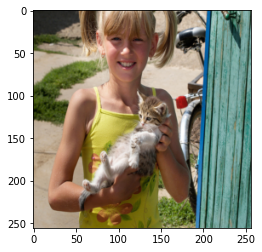

Labels: ['Girl in a tank top holding a kitten in her back yard'
 'A young girl is holding a small cat.'
 'A girl smiles as she holds a kitty cat.'
 'Girl with a yellow shirt holding a small cat'
 'A little girl holding a kitten next to a blue fence.']
Pred: <pad> A woman holding a cat and a dog.



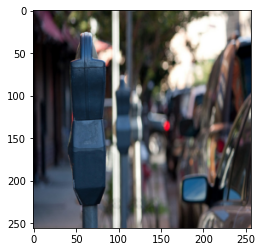

Labels: ['A row of cars parked on a street with parking meters.'
 'A parking meter on a street by a car with traffic.'
 'A series of parking meters and cars are located next to each other. '
 'A row of parked cars sitting next to parking meters.'
 'A parking meter on a street with cars']
Pred: <pad> A blue car is parked in a street.



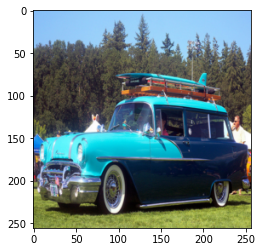

Labels: ['An old station wagon with a surfboard on top of it.'
 'An old car with surfboards on the top.'
 'An old vehicle painted light blue and dark blue.'
 'A car with some surfboards in a field.'
 'The old fashioned car is carrying some retro surfboards.']
Pred: <pad> A blue truck with a surfboard on top of it.



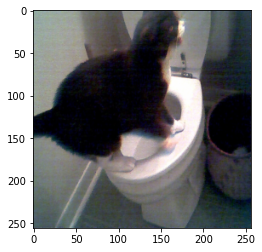

Labels: ['A cat standing on the toilet bowl seat'
 'A cat standing on a toilet with an open lid.'
 'A blurry picture of a cat standing on a toilet.'
 'A cat is perched on the top of a toilet seat in the bathroom.'
 'A cat on the lid of a toilet looking perturbed.']
Pred: <pad> A cat sitting on the toilet seat of a toilet.



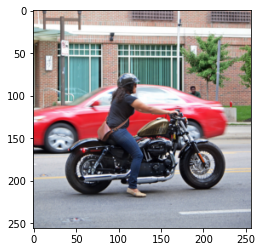

Labels: ['A woman sits on her motorcycle in the street.'
 'A woman on a motorcycle wearing a bag and passing a car. '
 'A woman on a motor cycle on a city street'
 'A woman is riding a motorcycle down the street.'
 'A woman on a motorcycle in the middle of the street.']
Pred: <pad> A woman riding a motorcycle with a side car.



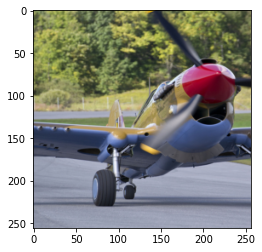

Labels: ['A small airplane taking off from an airport runway.'
 'A small airplane that is getting ready to take off from the runway. '
 'An airplane is about to fly into the sky. '
 'A Curtiss P-40 Warhawk taxis along a runway.'
 'a small air plane getting ready to take off .']
Pred: <pad> A small plane is parked on the runway.



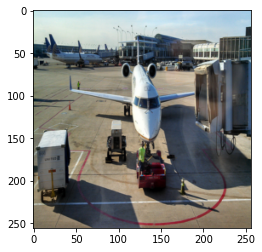

Labels: ['An airplane sits on the tarmac of an airport, with a disconnected boarding gate.'
 'Plane boarding passengers while at a fancy airport'
 'A plan parked on the cement near a terminal.'
 'A plane sitting on a runway getting ready to be emptied.'
 'THIS IS A AIRPLANE ON THE RUNWAY OF THE AIRPORT']
Pred: <pad> A large white airplane parked on a runway.



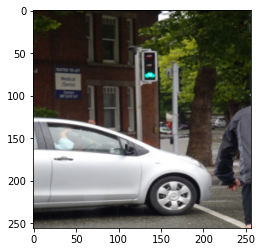

Labels: ['a car is stopped in the street for people to cross'
 'A car at an intersection while a man is crossing the street. '
 'a white car is pulled up and stopped at a line'
 'a silver car under a signal light that is green with a man in the  crosswalk'
 'A car that is sitting near a green street light.']
Pred: <pad> A white car parked in front of a building.



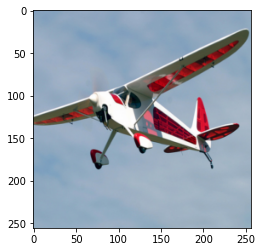

Labels: ['Red and white small plane on partially cloudy day.'
 'A plane that is flying in the air.'
 'A small lightweight airplane flying through the sky.'
 'A small plane flying through a cloudy blue sky.'
 'A red and white biplane in a blue, cloudy sky.']
Pred: <pad> A red and white airplane flying in the sky.



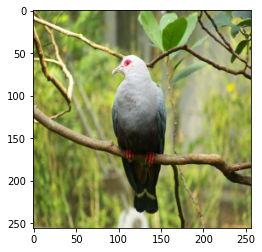

Labels: ['A grey and white bird with red feet and eyes perches on a branch. '
 'a bird with a pink eye is sitting on a branch in the woods.'
 'A bird with red eyes perched on top of a tree branch.'
 'A bird with red eyes and claws is perched on a branch. '
 'a black and white bird with red eyes sitting on a tree branch ']
Pred: <pad> A bird perched on a branch of a tree.



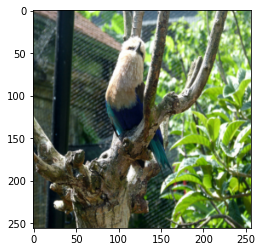

Labels: ['A bird in a tree in a cage.' 'A bird that is on a tree limb.'
 'A bird with blue feathers in a tree at the zoo'
 'a white headed bird perched in a tree in an enclosure'
 'BEAUTIFUL UNUSUAL BIRD INSIDE OF A BIRD SANTUARY']
Pred: <pad> A bird perched on top of a tree branch.



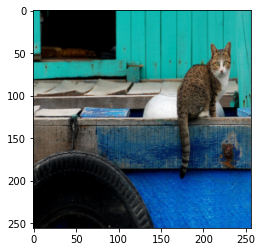

Labels: ['A small cat is sitting on the wooden beam.'
 'A cat with large eyes sitting on the side of the dock.'
 'A brown striped cat looks at the camera.'
 'A brown and white cat standing on wooden ledge ned to a building.'
 'This cat is sitting on a porch near a tire.']
Pred: <pad> A cat sitting on a bench in a park.



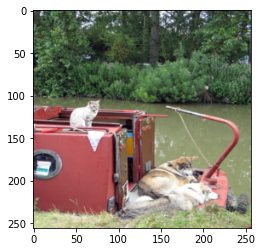

Labels: ['a cat and some dogs sunbathing by the water'
 'A cat sitting on top of a red boat next to two dogs.'
 'A white cat sits on a large red object by a river'
 'Two dogs and a cat on a boat at edge of water.'
 'A cat and two dogs rest by a pond.']
Pred: <pad> A dog laying on the ground next to a red truck.



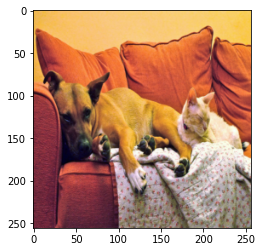

Labels: ['A dog and cat are sleeping together on an orange couch.'
 'A dog and a cat curled up together on a couch.'
 'A cat and dog napping together on the couch.'
 'A dog and cat lying  together on an orange couch. '
 'A cat and a dog rest together on a hideous orange couch.']
Pred: <pad> A dog and a cat laying on a couch.



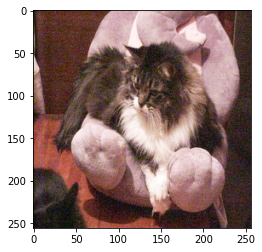

Labels: ['A cat sitting on top of a stuffed animal. '
 'a cat lays down on a stuffed animal'
 'A cat sitting in a chair that looks like an elephant'
 'a fat cat sits on a stuffed animal'
 'A spoiled cat is sitting on his own personal chair.']
Pred: <pad> A cat laying on a chair with a stuffed animal.



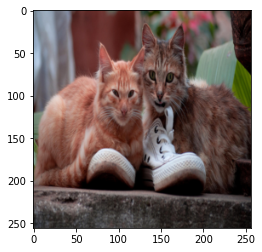

Labels: ['Two cats sitting on top of a pair of shoes.'
 'Two cats are sitting on a pair of shoes outdoors.'
 'Two striped cats lying with two sneakers on a ledge.'
 'Orange and brown cat sitting on top of white shoes. '
 "Two cats are outside and perched on someone's sneakers."]
Pred: <pad> A cat laying on a table next to a stuffed animal.



In [ ]:
from matplotlib import pyplot as plt
import cv2


val_loader = DataLoader(val_set, batch_size=1, collate_fn=collate_all)


for batch, i in zip(val_loader, range(16)):
        
    images, labels, tokens = batch

    model.eval()
    model.cpu()

    pred_tokens = model(batch)

    decoded_preds = [model.tokenizer.decode(t) for t in pred_tokens]

    for image, label, pred in zip(images, labels, decoded_preds):
        plt.imshow((image.squeeze(0).numpy().transpose(1, 2, 0)+1) / 2)
        plt.show()
        print(f'Labels: {label}\nPred: {pred}\n')

In [ ]:
from matplotlib import pyplot as plt
import cv2


val_loader = DataLoader(val_set, batch_size=1, collate_fn=collate_all)


for batch, i in zip(val_loader, range(16)):
        
    images, labels, tokens = batch

    model.eval()
    model.cpu()

    pred_tokens = model(batch)

    decoded_preds = [model.tokenizer.decode(t) for t in pred_tokens]

    for image, label, pred in zip(images, labels, decoded_preds):
        plt.imshow((image.squeeze(0).numpy().transpose(1, 2, 0)+1) / 2)
        plt.show()
        print(f'Labels: {label}\nPred: {pred}\n')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from matplotlib import pyplot as plt
import cv2


val_loader = DataLoader(val_set, batch_size=1, collate_fn=collate_all)


for batch, i in zip(val_loader, range(16)):
        
    images, labels, tokens = batch

    model.eval()
    model.cpu()

    pred_tokens = model(batch)

    decoded_preds = [model.tokenizer.decode(t) for t in pred_tokens]

    for image, label, pred in zip(images, labels, decoded_preds):
        plt.imshow((image.squeeze(0).numpy().transpose(1, 2, 0)+1) / 2)
        plt.show()
        print(f'Labels: {label}\nPred: {pred}\n')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from matplotlib import pyplot as plt
import cv2


val_loader = DataLoader(val_set, batch_size=1, collate_fn=collate_all)


for batch, i in zip(val_loader, range(16)):
        
    images, labels, tokens = batch

    model.eval()
    model.cpu()

    pred_tokens = model(batch)

    decoded_preds = [model.tokenizer.decode(t) for t in pred_tokens]

    for image, label, pred in zip(images, labels, decoded_preds):
        plt.imshow((image.squeeze(0).numpy().transpose(1, 2, 0)+1) / 2)
        plt.show()
        print(f'Labels: {label}\nPred: {pred}\n')

Output hidden; open in https://colab.research.google.com to view.

# Testes

In [ ]:
from nltk.translate import meteor
from nltk import word_tokenize

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.translate import bleu
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
meteor([word_tokenize("this is an apple"), word_tokenize("this is an apple")],
        word_tokenize('a car is parked in front of the library'))

0.11111111111111112

In [ ]:
['A horse drawn carriage is traveling a city street on a rainy night.'
 'A horse and carriage ride down a rainy city street.'
 'A crowded city filled with lots of people and traffic.'
 'an image of a night scene walking in rain'
 'Sepia photograph of horse drawn carriage in a street.']

In [ ]:
bleu(['John loves Mary'.split()], 'John loves Mary'.split(),(1,),)*100

100.0

In [ ]:
round(bleu(['A horse drawn carriage is traveling a city street on a rainy night.'.split(),
      'A horse and carriage ride down a rainy city street.'.split(),
      'A crowded city filled with lots of people and traffic.'.split(),
      'an image of a night scene walking in rain'.split()],
     
      'Sepia photograph of horse drawn carriage in a street.'.split(),(1,),)*100, 4)

77.7778

In [ ]:
sentences = ['A picture of stuffed animals on the street.',
'A telephone is decorated like a memorial with candles.',
'A tree with balloons tied onto it and candles at the base of it.',
'The tree is covered in stuffed animals and balloons.',
'A street side tree is filled with candles, teddy bears and balloons.']

In [ ]:
round(bleu([i.split() for i in sentences[:4]], sentences[4].split(),(1,),)*100, 4)

66.6667

In [ ]:
round(bleu([i.split() for i in sentences], 'A room with a clock and a plant in it'.split(),(1,),)*100, 4)

60.0

In [ ]:
h = [1,2,3,4,5]

In [ ]:
h.remove(1)
h

[2, 3, 4, 5]

In [ ]:
sentences[1,3]

TypeError: ignored

In [ ]:
sentences = ['A dining room window with many potted and hanging plants.',
             'Several potted plants in front of a window.',
             'Plants sitting near an open window inside a house. ',
             'A chair and some plants are sitting next to the window.',
             'A window in a kitchen filled with green plants.']

In [ ]:
from nltk.translate import meteor
from nltk import word_tokenize

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.translate import bleu
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4

def metricas(sentences):

    bs, b4, me = 0, 0, 0
    for i in range(5):
        h = [0, 1, 2, 3, 4]
        s = h.remove(i)

        bs += bleu([sentences[k].split() for k in h], sentences[i].split(),(1,),)*100
        b4 += bleu([sentences[k].split() for k in h], sentences[i].split(), smoothing_function=smoothie)*100
        me += meteor([word_tokenize(sentences[k]) for k in h], word_tokenize(sentences[i]))*100

    b4_mean  = b4/5
    bs_mean  = bs/5
    meteor_m = me/5

    print('Bleu-Score:', round(bs_mean, 4))
    print('Bleu-4:    ', round(b4_mean, 4))
    print('Meteor:    ', round(meteor_m, 4))

metricas(sentences)

Bleu-Score: 52.1221
Bleu-4:     3.6178
Meteor:     30.7706


In [ ]:
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4

b4 = 0
for i in range(5):
    h = [0, 1, 2, 3, 4]
    s = h.remove(i)

    l = [sentences[k].split() for k in h]

    b4 += bleu(l, sentences[i].split(), smoothing_function=smoothie)*100
    print("Sentença", str(i+1) + ":", round(bleu(l, sentences[i].split(), smoothing_function=smoothie)*100, 4))

print(round(b4/5, 4))

Sentença 1: 3.6713
Sentença 2: 3.7741
Sentença 3: 3.3866
Sentença 4: 3.2297
Sentença 5: 4.0274
3.6178


In [ ]:
b=0
for i in range(5):
    h = [0, 1, 2, 3, 4]
    s = h.remove(i)

    b += bleu([sentences[k].split() for k in h], sentences[i].split(),(1,),)*100

print(round(b/5, 4))

52.1221


In [ ]:
for i in range(5):
    h = [0, 1, 2, 3, 4]
    s = h.remove(i)

    print("Sentença", str(i+1) + ":", round(bleu([sentences[k].split() for k in h], sentences[i].split(),(1,),)*100, 4))

Sentença 1: 60.0
Sentença 2: 55.1561
Sentença 3: 33.3333
Sentença 4: 45.4545
Sentença 5: 66.6667


In [ ]:
round(bleu([i.split() for i in sentences], 'A room with a clock and a plant in it'.split(),(1,),)*100, 4)

60.0

In [ ]:
m=0
for i in range(5):
    h = [0, 1, 2, 3, 4]
    s = h.remove(i)

    m += meteor([word_tokenize(sentences[k]) for k in h], word_tokenize(sentences[i]))

print(round(m/5, 4))

0.3077


In [ ]:
meteor([word_tokenize(k) for k in sentences], word_tokenize('A room with a clock and a plant in it'))

0.2808302808302808

In [ ]:
b=0
for i in range(5):
    h = [0, 1, 2, 3, 4]
    s = h.remove(i)

    b += bleu([sentences[k].split() for k in h], sentences[i].split(), smoothing_function=smoothie)*100

print(round(b/5, 4))

3.6178
